## Applying the bias scan tool on a loan approval classifier
In this notebook, the bias scan tool is applied on a XGBoost loan approval classifier. The bias scan tool is based on an implementation of the k-means Hierarchical Bias Aware Clustering (HBAC) method\*. The python script `./helper_functions.py` contains functions that execute the bias scan. A conceptual description how the bias scan works, including the rationale why k-means is chosen as a clustering algorithm and paramater choices, can be found in the [bias scan tool report](https://github.com/NGO-Algorithm-Audit/AI_Audit_Challenge/blob/master/Bias_scan_tool_report.docx).

The classifier is used to make predictions on the German Credit\*\* data set. Details on pre-processing steps performed on this dataset and the trained XGBoost classifier are provided in the `../classification_models/Loan_approval_classifier/GermanCredit_classifier.ipynb` notebook.

This notebook is structured as follows:
1. Load data and pre-processing
2. Bias scan using k-means clustering
3. Clustering results
4. Statistical testing of inter-cluster difference 

\* Misztal-Radecka, Indurkya, *Information Processing and Management*. Bias-Aware Hierarchical Clustering for detecting the discriminated groups of users in recommendation systems (2021).

\*\* the original dataset, in the form provided by Prof. Hofmann, contains categorical/symbolic attributes and is in the file "german.data" [[link to dataset]](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29)

### Load libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# helper functions
from helper_functions import *

# sklearn
from sklearn.preprocessing import StandardScaler

# welch's t-test
import scipy.stats as stats

### 1. Load data and pre-processing
#### Load data

In [2]:
path = '../classification_models/Loan_approval_classifier/pred_XGBoost.csv'

# read data
entire_dataset = pd.read_csv(path)
entire_dataset.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors
0,21.0,2993.0,3.0,2.0,28.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
1,30.0,3656.0,4.0,4.0,49.0,2.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
2,12.0,1255.0,4.0,4.0,61.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
3,8.0,1414.0,4.0,2.0,33.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0
4,12.0,691.0,4.0,3.0,35.0,2.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1.0,1.0


#### Data cleaning

In [3]:
features = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)
features.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
0,21.0,2993.0,3.0,2.0,28.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,30.0,3656.0,4.0,4.0,49.0,2.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,12.0,1255.0,4.0,4.0,61.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,8.0,1414.0,4.0,2.0,33.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,12.0,691.0,4.0,3.0,35.0,2.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


#### Scaling data

In [6]:
full_data = initialize_GermanCredit_dataset(entire_dataset,features)
full_data.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
0,0.060492,0.002162,-0.049437,-0.764268,-0.665129,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.0,0,0.0,0.0,0,-1
1,0.823703,0.254090,0.877513,1.084768,1.180823,0.943341,-0.447214,-0.623610,-0.592749,3.554766,...,0.839372,-0.839372,0.195096,-0.195096,0.0,0,0.0,0.0,0,-1
2,-0.702720,-0.658246,0.877513,1.084768,2.235653,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.0,0,0.0,0.0,0,-1
3,-1.041925,-0.597829,0.877513,-0.764268,-0.225616,-0.711644,-0.447214,-0.623610,1.687055,-0.281312,...,0.839372,-0.839372,-5.125693,5.125693,0.0,0,0.0,0.0,0,-1
4,-0.702720,-0.872556,0.877513,0.160250,-0.049811,0.943341,-0.447214,1.603567,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.8,0,1.0,1.0,0,-1


### 2. Bias scan using k-means clustering
Clustering algorithms parameters:

In [7]:
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 300,
    "random_state": 10,
}

Specify:
- Minimal splittable cluster size
- Minimal acceptable cluster size

In [8]:
# minimal splittable cluster size
split_cluster_size = round(0.05 * len(full_data))
print("minimal splittable cluster size: ", split_cluster_size)

# minimal acceptable cluster size
acc_cluster_size = round(0.03 * len(full_data))
print("minimal splitacceptabletable cluster size: ", acc_cluster_size)

minimal splittable cluster size:  15
minimal splitacceptabletable cluster size:  9


Performing bias scan using helper functions.

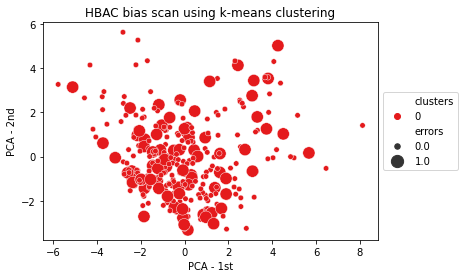

average_accuracy is:  0.75


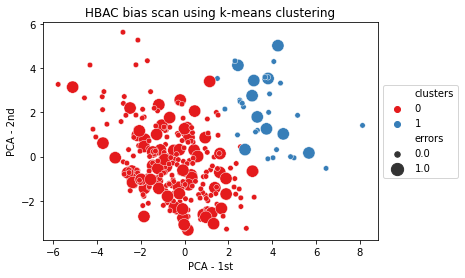

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1


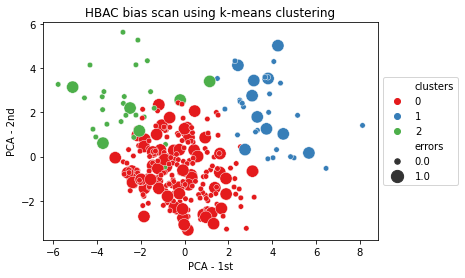

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1


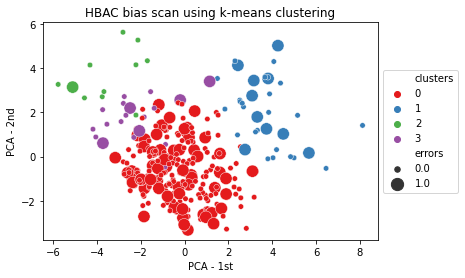

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1


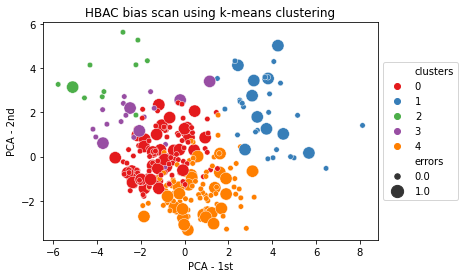

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1


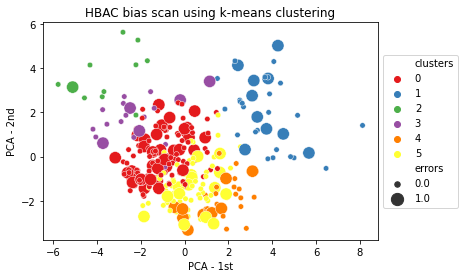

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 4


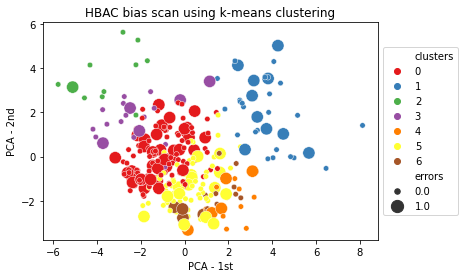

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 4
MAX_ITER
[0.000996390674420978, 0.000996390674420978, 0.000996390674420978, 0.001690546420486664, 0.001690546420486664, 0.006231794690689193, 0.006231794690689193, 0.005316066110689393, 0.005316066110689393, 0.005316066110689393, 0.005747992737386108, 0.005851628012998611, 0.005851628012998611, 0.005851628012998611, 0.005851628012998611, 0.005851628012998611, 0.005851628012998611, 0.005851628012998611]


In [10]:
MAX_ITER = 20
x = 0 # initial cluster number
initial_bias = 0
pca_plot(full_data)
variance_list = []
average_accuracy = accuracy(full_data)
split_cluster_size = 16 
acc_cluster_size = 10
minimal_splittable_cluster_size = split_cluster_size
minimal_acceptable_cluster_size = acc_cluster_size
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(variance_list)

### 3. Analysing clustering results
Identifying highest biased cluster

In [11]:
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
print(f"cluster {c} has the highest discrimination bias")
print("#elements in highest biased cluster:", len(highest_biased_cluster))

0 has bias -0.030722315779891596
2 has bias 0.1651462724127084
5 has bias 0.05883772856194547
4 has bias -0.08771929824561409
1 has bias -0.031565656565656575
3 has bias 0.0
6 has bias -0.029550827423167836
cluster 4 has the highest discrimination bias
#elements in highest biased cluster: 15


Accuracy of classifier on full dataset and on cluster with highest discrimination bias.

In [12]:
accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)

General accuracy of classifier on this dataset: 0.75


Select and print discriminated cluser.

In [13]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

Number of instances in discriminated cluster: 15
Number of errors in discriminated clusters:  5


,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
6,0.314895,0.334646,0.877513,-0.764268,0.477604,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
18,0.060492,0.109317,-1.903339,1.084768,0.038091,-0.711644,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
49,1.332510,3.034796,0.877513,-0.764268,-0.840934,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,1,1.0,0.0,4,-1.0
69,1.332510,1.084730,-0.976388,-0.764268,-0.049811,0.943341,2.236068,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
120,0.314895,-0.243686,0.877513,0.160250,-0.049811,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
130,-0.957124,-0.564771,-0.976388,0.160250,-0.137714,0.943341,-0.447214,-0.62361,1.687055,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.8,0,1.0,1.0,4,-1.0
135,-0.193912,0.301208,-0.049437,-0.764268,-0.049811,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
145,0.314895,1.464712,-0.976388,1.084768,0.917116,0.943341,2.236068,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
165,2.350125,0.801264,-0.976388,0.160250,-0.489324,-0.711644,-0.447214,-0.62361,1.687055,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.8,0,1.0,1.0,4,-1.0
179,1.078107,1.620884,-0.049437,-0.764268,-0.049811,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0


### 4. Statistical testing of inter-cluster difference 
Compute difference between cluster with highest discrimination bias and rest of dataset.

In [21]:
not_discriminated = full_data[full_data['clusters']!=c]
difference = (discriminated_cluster.mean()) - (not_discriminated.mean()) 
diff_dict = difference.to_dict()
difference

month                              0.813497
credit_amount                      1.077397
investment_as_income_percentage   -0.117089
residence_since                   -0.220587
age                                0.095613
                                     ...   
predicted_class                   -0.133333
true_class                         0.010526
errors                             0.087719
clusters                           1.926316
new_clusters                      -0.108772
Length: 63, dtype: float64

Unscaling the data. Print summary of cluster with highest discrimination bias and the rest of data.

In [22]:
# unscaling the discriminated cluster
unscaled_discriminated = full_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = full_data.drop(discriminated_cluster.index)

display(unscaled_remaining.describe())
display(unscaled_discriminated.describe())

print(discriminated_cluster.index)

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,-0.040675,-0.053870,0.005854,0.011029,-0.004781,-0.026422,-0.004708,0.032822,0.015199,0.014806,...,0.055578,-0.055578,-0.010268,0.010268,0.196491,0.266667,0.322807,0.245614,2.073684,-0.891228
std,0.990740,0.968734,1.005221,1.015393,1.017026,0.997371,0.997521,1.017210,1.009941,1.025640,...,0.990348,0.990348,1.026753,1.026753,0.344966,0.442995,0.468372,0.431208,2.303895,0.434547
min,-1.381130,-1.006689,-1.903339,-1.688786,-1.368349,-0.711644,-0.447214,-0.623610,-0.592749,-0.281312,...,-1.191367,-0.839372,-5.125693,-0.195096,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,-0.702720,-0.649507,-0.976388,-0.764268,-0.840934,-0.711644,-0.447214,-0.623610,-0.592749,-0.281312,...,-1.191367,-0.839372,0.195096,-0.195096,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,-0.193912,-0.404038,-0.049437,0.160250,-0.225616,-0.711644,-0.447214,-0.623610,-0.592749,-0.281312,...,0.839372,-0.839372,0.195096,-0.195096,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000
75%,0.314895,0.174674,0.877513,1.084768,0.653408,0.943341,-0.447214,1.603567,1.687055,-0.281312,...,0.839372,1.191367,0.195096,-0.195096,0.000000,1.000000,1.000000,0.000000,5.000000,-1.000000
max,3.367741,4.481766,0.877513,1.084768,3.466288,4.253312,2.236068,1.603567,1.687055,3.554766,...,0.839372,1.191367,0.195096,5.125693,0.800000,1.000000,1.000000,1.000000,6.000000,1.000000


,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,1.500000e+01,15.000000,1.500000e+01,...,15.000000,15.000000,1.500000e+01,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.0,15.0
mean,0.772822,1.023528,-0.111234,-0.209557,0.090833,0.502012,0.089443,-6.236096e-01,-0.288775,-2.813124e-01,...,-1.055984,1.055984,1.950956e-01,-1.950956e-01,0.266667,0.133333,0.333333,0.333333,4.0,-1.0
std,0.918273,1.100013,0.957351,0.681174,0.660983,0.982427,1.110984,2.298380e-16,0.802185,5.745950e-17,...,0.524335,0.524335,2.872975e-17,5.745950e-17,0.390360,0.351866,0.487950,0.487950,0.0,0.0
min,-0.957124,-0.564771,-1.903339,-0.764268,-0.840934,-0.711644,-0.447214,-6.236096e-01,-0.592749,-2.813124e-01,...,-1.191367,-0.839372,1.950956e-01,-1.950956e-01,0.000000,0.000000,0.000000,0.000000,4.0,-1.0
25%,0.314895,0.219322,-0.976388,-0.764268,-0.313519,-0.711644,-0.447214,-6.236096e-01,-0.592749,-2.813124e-01,...,-1.191367,1.191367,1.950956e-01,-1.950956e-01,0.000000,0.000000,0.000000,0.000000,4.0,-1.0
50%,0.314895,0.801264,-0.049437,-0.764268,-0.049811,0.943341,-0.447214,-6.236096e-01,-0.592749,-2.813124e-01,...,-1.191367,1.191367,1.950956e-01,-1.950956e-01,0.000000,0.000000,0.000000,0.000000,4.0,-1.0
75%,1.332510,1.692321,0.877513,0.160250,0.345750,0.943341,-0.447214,-6.236096e-01,-0.592749,-2.813124e-01,...,-1.191367,1.191367,1.950956e-01,-1.950956e-01,0.800000,0.000000,1.000000,1.000000,4.0,-1.0
max,2.350125,3.065194,0.877513,1.084768,1.620336,2.598327,2.236068,-6.236096e-01,1.687055,-2.813124e-01,...,0.839372,1.191367,1.950956e-01,-1.950956e-01,0.800000,1.000000,1.000000,1.000000,4.0,-1.0


Int64Index([6, 18, 49, 69, 120, 130, 135, 145, 165, 179, 198, 220, 227, 228,
            243],
           dtype='int64')


In [23]:
unscaled_discriminated

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
6,0.314895,0.334646,0.877513,-0.764268,0.477604,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
18,0.060492,0.109317,-1.903339,1.084768,0.038091,-0.711644,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
49,1.332510,3.034796,0.877513,-0.764268,-0.840934,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,1,1.0,0.0,4,-1.0
69,1.332510,1.084730,-0.976388,-0.764268,-0.049811,0.943341,2.236068,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
120,0.314895,-0.243686,0.877513,0.160250,-0.049811,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
130,-0.957124,-0.564771,-0.976388,0.160250,-0.137714,0.943341,-0.447214,-0.62361,1.687055,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.8,0,1.0,1.0,4,-1.0
135,-0.193912,0.301208,-0.049437,-0.764268,-0.049811,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
145,0.314895,1.464712,-0.976388,1.084768,0.917116,0.943341,2.236068,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0
165,2.350125,0.801264,-0.976388,0.160250,-0.489324,-0.711644,-0.447214,-0.62361,1.687055,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.8,0,1.0,1.0,4,-1.0
179,1.078107,1.620884,-0.049437,-0.764268,-0.049811,0.943341,-0.447214,-0.62361,-0.592749,-0.281312,...,-1.191367,1.191367,0.195096,-0.195096,0.0,0,0.0,0.0,4,-1.0


####  Test to check statistical significance of inter-cluster difference (per feature)
Applying a Welch’s two-samples t-test for unequal variances to examine whether the differences in means for each feature are statistically significant and store results in a dictionary.

In [24]:
welch_dict = {}
    
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    
    # attach to dictionary
    welch_dict[i] = welch_i.pvalue
    
welch_dict

{'month': 0.0043092808997596274,
 'credit_amount': 0.002026560522486944,
 'investment_as_income_percentage': 0.651475463283113,
 'residence_since': 0.25123798031854805,
 'age': 0.6038608869290973,
 'number_of_credits': 0.059938553197510076,
 'people_liable_for': 0.7522316363891863,
 'status=A11': 2.5263312826516818e-23,
 'status=A12': 0.17720243322963358,
 'status=A13': 1.820892571622187e-06,
 'status=A14': 5.934641857157464e-05,
 'credit_history=A30': 0.0008362740563660706,
 'credit_history=A31': 9.035742570166901e-05,
 'credit_history=A32': 0.027976426638826636,
 'credit_history=A33': 1.084424480599988e-07,
 'credit_history=A34': 0.0011716892424357465,
 'purpose=A40': 2.8663351482443026e-18,
 'purpose=A41': 0.0030452591754603874,
 'purpose=A410': 0.08326259833236539,
 'purpose=A42': 0.5312216857642652,
 'purpose=A43': 6.866500587830593e-25,
 'purpose=A44': 0.02508728636916385,
 'purpose=A45': 0.004496027856176419,
 'purpose=A46': 0.8391638290098318,
 'purpose=A48': 0.0140474478350120

p-values: A small p-value (p < 0.05) indicates that it is unlikely to observe inter-cluster difference due to chance. Since the features are still one-hot encoded, p-values should be assessed with respect to the values assigned to the data variables, which complicates the analysis. Based on an overall assessment of the p-values per variables, i.e., considering that the p-values for `skill_level=A171,A172,A173,A74` are all below 0.05, we derive at the following conclusion.

#### Conclusion
Suspected bias by the loan approval classification tool on the basis of:
- Job status (`skill_level`)
- Credit history
- Duration of the loan
- Amount requested